## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [2]:
print("You may see error or warning messages, but that is okay. Proceed to the next cell.")

!pip --disable-pip-version-check -q  install transformers
!pip --disable-pip-version-check -q install pyathena
#!pip --disable-pip-version-check -q install torch==1.5.0
!pip --disable-pip-version-check -q install sagemaker-experiments==0.1.26

You may see error or warning messages, but that is okay. Proceed to the next cell.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sagemaker 2.143.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.1.0 which is incompatible.
sagemaker 2.143.0 requires PyYAML==5.4.1, but you have pyyaml 6.0 which is incompatible.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.


In [3]:
# General imports
import pandas as pd
import numpy as np
import collections
import io
import time
from smexperiments.trial import Trial
from smexperiments.experiment import Experiment
import uuid

# nlp processing imports
import string
import re
import nltk
from transformers import DistilBertTokenizer
from transformers import DistilBertModel


# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
from sagemaker import get_execution_role
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import Rule
from sagemaker.debugger import rule_configs
from sagemaker.debugger import ProfilerRule
from sagemaker.debugger import CollectionConfig
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.tensorflow import TensorFlow


# athena connection imports
from pyathena import connect
import boto3

#import torch
from sagemaker.pytorch import PyTorch
#import torch.nn as nn
#from torch.utils.data import TensorDataset, DataLoader

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Establishing Athena for SQL Queries

In [4]:
region = boto3.Session().region_name
role = get_execution_role()
sm = boto3.Session(region_name=region).client(service_name="sagemaker", region_name=region)

In [5]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

# this sets the bucket to the default sagemaker bucket
bucket = session.default_bucket()
print(bucket)

sagemaker-us-west-2-692349450615


Create folder within s3 bucket named youtubeStatistics

In [6]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [7]:
# temp query storage
s3_athena = "s3://{}/athena/tmp/".format(bucket)

# file storage
youtube_dir = "s3://{}/athena/files/".format(bucket)

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [8]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [9]:
# set the names of folders holding different datasets
csv_folder = "csv"
json_folder = "json"

In [10]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/{csv_folder}/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [11]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,E-oA1BWRL2U,Minecraft but there's Only One Modded Block,2023-01-02T18:05:07Z,UC_cvTMeip9po2hZdF3aBXrA,BeckBroJack,20,2023-01-05T00:00:00Z,minecraft|minecraft but theres only one block|...,294697,22001,0,1228,https://i.ytimg.com/vi/E-oA1BWRL2U/default.jpg,False,False,Today I survived on one Modded Block in Minecr...
1,PpznJj8ZXMY,Rangers 2-2 Celtic | Late Furuhashi Goal Denie...,2023-01-02T22:00:06Z,UCakRszbIjjGYtFrDPeg5Ieg,SPFL,17,2023-01-05T00:00:00Z,SPFL|SPFL Highlights|Scottish football highlig...,596283,3049,0,1003,https://i.ytimg.com/vi/PpznJj8ZXMY/default.jpg,False,False,Celtic kept their 9 point lead at the top of t...
2,8DNLvMTxhb8,I Cut My Long Hair SHORT *and surprised my fam...,2023-01-01T18:00:02Z,UCzzOKT1SkE7qdycJvPCR3Gg,Mia Maples,26,2023-01-05T00:00:00Z,mia maples|cutting bangs|giving myself bangs|c...,1001653,92538,0,17372,https://i.ytimg.com/vi/8DNLvMTxhb8/default.jpg,False,False,HAPPY NEW YEAR.. Today I CHOPPED MY HAIR OFF l...
3,IHATf7e53hU,Former FBI agent sheds light on Poconos arrest...,2023-01-02T13:08:14Z,UCqdOvfSmM2NKRNE0FSbATuw,FOX 29 Philadelphia,25,2023-01-05T00:00:00Z,Good Day|video|wtxf|third party|Idaho|Idaho Mu...,309838,2328,0,963,https://i.ytimg.com/vi/IHATf7e53hU/default.jpg,False,False,Retired Supervisory Special Agent of the FBI S...
4,n_DtpY9wbGg,Dude Perfect vs. Luka Doncic (1-on-1),2022-12-31T14:59:56Z,UCRijo3ddMTht_IHyNSNXpNQ,Dude Perfect,17,2023-01-05T00:00:00Z,dude perfect|dude perfect stereotypes|dude per...,8626982,330563,0,7482,https://i.ytimg.com/vi/n_DtpY9wbGg/default.jpg,False,False,"Cody vs Luka in 1-on-1, Trick Shots with Luka,..."
5,naQ0RuXB3fI,Uncle Roger Learn To Make Lobster Roll (ft. NI...,2023-01-01T14:00:17Z,UCVjlpEjEY9GpksqbEesJnNA,mrnigelng,23,2023-01-05T00:00:00Z,nigel ng|uncle roger|nigel ng comedy,1480796,86621,0,3349,https://i.ytimg.com/vi/naQ0RuXB3fI/default.jpg,False,False,Uncle Nick (@NickDiGiovanni) teach Uncle Roger...
6,SEdAFDl_2g4,Miley Cyrus & Dolly Parton Sing Wrecking Ball ...,2023-01-01T05:58:45Z,UCccjdJEay2hpb5scz61zY6Q,NBC,24,2023-01-05T00:00:00Z,new years eve|nbc|mileys new years eve party|m...,3218572,82629,0,4188,https://i.ytimg.com/vi/SEdAFDl_2g4/default.jpg,False,False,Miley Cyrus and Dolly Parton perform a medley ...
7,G8w42dfxNg8,Future - BACK TO THE BASICS (Official Music Vi...,2023-01-02T20:00:02Z,UCSDvKdIQOwTfcyOimSi9oYA,Future,10,2023-01-05T00:00:00Z,future|future hndrxx|pluto|wizrd|wizard|i neve...,528459,35441,0,1636,https://i.ytimg.com/vi/G8w42dfxNg8/default.jpg,False,False,Future - BACK TO THE BASICS (Official Music Vi...
8,97ICETWIrW8,I Collected EVERY Block in Minecraft Hardcore,2023-01-01T14:00:52Z,UCJLklPT2rmAF33gVyHYH-QQ,ezY,20,2023-01-05T00:00:00Z,ezyyhd|ezy|ezyy|ezzy|ezy minecraft|I Collected...,959016,33553,0,3416,https://i.ytimg.com/vi/97ICETWIrW8/default.jpg,False,False,Today I Collected EVERY Block in Hardcore Mine...
9,2FcDNi1HkfI,Happy New Year Live! 🎆 London Fireworks 2023 🔴...,2023-01-01T00:15:15Z,UCCj956IF62FbT7Gouszaj9w,BBC,24,2023-01-05T00:00:00Z,fireworks|NYE|new year countdown 2023|firework...,4181839,43283,0,4795,https://i.ytimg.com/vi/2FcDNi1HkfI/default.jpg,False,False,Subscribe and 🔔 to the BBC 👉 https://bit.ly/BB...


In [12]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/{csv_folder}/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [13]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,P1Ohc8GDFPI,Deion Sanders receives his flowers from Shanno...,2022-12-20T17:30:08Z,UCQoxJOkwaCgyzQtiuAIDcuw,Club Shay Shay,22,2023-01-03T00:00:00Z,Club Shay Shay|fs1|fox sports|fs1 Club Shay Sh...,2958648,75990,0,6832,https://i.ytimg.com/vi/P1Ohc8GDFPI/default.jpg,False,False,"Club Shay Shay heads to Boulder, Colorado this..."
1,QQOplWjM910,World's Largest Axe Vs. GIANT Rubber Band Ball,2022-12-22T22:00:19Z,UC5f5IV0Bf79YLp_p9nfInRA,How Ridiculous,17,2023-01-03T00:00:00Z,how ridiculous|rexy|44club,1523580,52641,0,2217,https://i.ytimg.com/vi/QQOplWjM910/default.jpg,False,False,Thanks to Epic Games for sponsoring - Fortnite...
2,ZK3x16AUUKI,Catch The Right Size Pokemon To Win,2022-12-21T19:23:18Z,UCLc_ZQgQ8h2XKUAQpqcvIdw,PM7,20,2023-01-03T00:00:00Z,pokemon|new pokemon|pokemon challenge|pm7 scar...,973478,29189,0,3170,https://i.ytimg.com/vi/ZK3x16AUUKI/default.jpg,False,False,Whoever catches the Pokemon closest to the ran...
3,QNuu8KTUEwU,Using a robot to cheat in a boxing match!,2022-12-21T15:00:13Z,UCJLZe_NoiG0hT7QCX_9vmqw,I did a thing,24,2023-01-03T00:00:00Z,[None],2697095,174638,0,4984,https://i.ytimg.com/vi/QNuu8KTUEwU/default.jpg,False,False,Get PayPal Honey for FREE today ▸ https://join...
4,IltuQkeU7zU,BADGER'S BEST OF 2022,2022-12-20T20:37:43Z,UCWzLmNWhgeh3h1j-M-Isy0g,TheRussianBadger,20,2023-01-03T00:00:00Z,[None],2501910,162376,0,11807,https://i.ytimg.com/vi/IltuQkeU7zU/default.jpg,False,False,BUY MY SHAKER CUP (use code BADGER for 10% off...
5,PR715VHT8LE,Bills safety Damar Hamlin taken to hospital af...,2023-01-03T04:10:31Z,UC9ha3sh4YTCSK83dH6OlWTw,WTVR CBS 6,25,2023-01-04T00:00:00Z,Richmond|Virginia,1015760,4426,0,1389,https://i.ytimg.com/vi/PR715VHT8LE/default.jpg,False,False,A Bills player was taken off the field in an a...
6,nCBVWlNLZ_I,Cotton Bowl: Tulane Green Wave vs. USC Trojans...,2023-01-02T22:05:59Z,UCzRWWsFjqHk1an4OnVPsl9g,ESPN College Football,17,2023-01-04T00:00:00Z,Cotton Bowl: Tulane Green Wave vs. USC Trojans...,913997,8113,0,2506,https://i.ytimg.com/vi/nCBVWlNLZ_I/default.jpg,False,False,Watch these highlights from the Tulane Green W...
7,4weFxATBEiY,Evil Dead Rise – Teaser,2023-01-03T17:00:26Z,UCjmJDM5pRKbUlVIzDYYWb6g,Warner Bros. Pictures,1,2023-01-04T00:00:00Z,Alyssa Sutherland|Bruce Campbell|Evil Dead|Evi...,348962,12956,0,1150,https://i.ytimg.com/vi/4weFxATBEiY/default.jpg,False,False,A little peek at what’s to come. New trailer f...
8,XHegE9h0ZvA,Center - Day 2 - Listen,2023-01-03T06:00:08Z,UCFKE7WVJfvaHW5q283SxchA,Yoga With Adriene,26,2023-01-04T00:00:00Z,home yoga|home yoga practice|yoga at home|at h...,604097,17963,0,1810,https://i.ytimg.com/vi/XHegE9h0ZvA/default.jpg,False,False,In this practice we embrace a key element to t...
9,R8L0szRdcVc,Ken Block: a look back at the career of the ra...,2023-01-03T15:59:58Z,UCwD9E_QNwFwrQC7OnPnrg2Q,Guardian Sport,17,2023-01-04T00:00:00Z,ken block|ken block best clips|ken block best ...,259170,3684,0,271,https://i.ytimg.com/vi/R8L0szRdcVc/default.jpg,False,False,"Professional rally driver Ken Block, who later..."


In [14]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/{csv_folder}/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [15]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,CG3XDu8aAf8,dodie: Tiny Desk Concert,2023-01-10T10:00:06Z,UC4eYXhJI4-7wSWc8UNRwD4A,NPR Music,10,2023-01-14T00:00:00Z,NPR|NPR Music|National Public Radio|Live|Perfo...,261463,21794,0,1218,https://i.ytimg.com/vi/CG3XDu8aAf8/default.jpg,False,False,"Robin Hilton | January 10, 2023On many levels,..."
1,6RjJEAX-z8Y,When an Anime only focuses on Boxing,2023-01-10T22:52:21Z,UC4G10tk3AHFuyMIuD3rHOBA,RDCworld1,23,2023-01-14T00:00:00Z,[None],866993,101590,0,5037,https://i.ytimg.com/vi/6RjJEAX-z8Y/default.jpg,False,False,FOLLOW @SUPREMEDREAMS_1 AND @RDCWORLD1 FOR MOR...
2,oecXah38C3c,I Got EVERY SHINY Pokémon From Scarlet and Vio...,2023-01-10T17:04:36Z,UCJoimug4KfsLcY6t_EoRaaA,Jayden Wilson,20,2023-01-14T00:00:00Z,pokemon scarlet and violet|shiny pokemon|pokem...,164458,3867,0,292,https://i.ytimg.com/vi/oecXah38C3c/default.jpg,False,False,I'm gonna be attempting to complete the ENTIRE...
3,3COY_HrMngc,YOU: Season 4 Part 1 | Official Trailer | Netflix,2023-01-09T15:00:03Z,UCWOA1ZGywLbqmigxE4Qlvuw,Netflix,24,2023-01-14T00:00:00Z,Amy-Leigh Hickman|Charlotte Ritchie|Ed Speleer...,3380351,93670,0,4108,https://i.ytimg.com/vi/3COY_HrMngc/default.jpg,False,False,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,Watch YOU,only on Netflix: https://www.netflix.com/titl...,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,SUBSCRIBE: http://bit.ly/29qBUt7,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,About Netflix:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


#### JSON Tables

In [16]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_json", conn)

us_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_json (
                        kind string, 
                        etag string, 
                        items ARRAY< struct< kind: string, 
                                             etag: string,
                                             id: string,
                                             snippet: ARRAY< struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://{bucket}/youtubeStatistics/{json_folder}/usa/US_category_id_test.json';
"""

pd.read_sql(us_json_create, conn)

""


In [17]:
query_json_us = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.us_json, 
                    UNNEST({db_name}.us_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_us, conn)

,kind,etag,id,title,assignable,channelId


In [18]:
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)

,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,youtubedb


In [19]:
if db_name in db_show.values:
    ingest_create_athena_db_passed = True

In [20]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


## Exploratory Data Analysis

#### US American Gaming Exploration

Preparing the data for exploration by adjusting the necessary column types.

### Initial Preprocesssing and transformations to visualize the data properly

#### Data Import 

The data set below is created from the United States area where categoryid = 20 or 'Gaming' category on Youtube. As many of the creators under our companies umbrella do create 'Gaming' content, it is a key area for ViewBoost to focus in on. It also provides an opportunity to refine a robust deep learning neural network as there is still 37,000 records within the US Gaming segment. 

In [21]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,gO0bJlXEG5w,The Story of Herobrine..,2021-10-17T20:00:48Z,UCSpfz1IyUA1NBH-cgj8ygUw,SeaWattgaming,20,2021-10-20T00:00:00Z,Seawattgaming|Seawatt|Seawatt gaming|The story...,1512593,48482,977,1923,https://i.ytimg.com/vi/gO0bJlXEG5w/default.jpg,False,False,This is basically The story of Minecraft's fir...
1,Vaz_Ex5nSDw,Where's 3000 Days?,2021-10-17T17:00:12Z,UC9FkeEFIGd9FXRfxpTltXYA,Luke TheNotable,20,2021-10-20T00:00:00Z,luke thenotable|luke|the|notable|minecraft|300...,1361815,108144,1425,6631,https://i.ytimg.com/vi/Vaz_Ex5nSDw/default.jpg,False,False,"In this video I answer the questions, Where's ..."
2,fq5o8R9Qa6A,We're Going to Worlds Finals for FREE! | Cloud...,2021-10-18T22:29:09Z,UCpGqU5C1gsrCNdYJ_Z0Qlug,Cloud9 League of Legends,20,2021-10-20T00:00:00Z,Cloud9|Cloud 9|C9|League of Legends|LCS|League...,243573,4762,132,691,https://i.ytimg.com/vi/fq5o8R9Qa6A/default.jpg,False,False,"Well, the Worlds 2021 Playoffs Bracket has bee..."
3,1QsMVcqgp0U,remember my name #shorts,2021-10-18T16:00:01Z,UCgB0bPjrj8YeUSC0v0vBuwA,MarkClarkk,20,2021-10-20T00:00:00Z,call of duty|MarkClarkk|jordy2d|call of duty w...,144304,5055,221,42,https://i.ytimg.com/vi/1QsMVcqgp0U/default.jpg,False,False,Like the video if you enjoyed 👍SUBSCRIBE to Ma...
4,2ImV4-58Ezg,All Of Ash's Abilities Leaked For Season 11 Ap...,2021-10-18T13:34:53Z,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Thordan Smash,20,2021-10-20T00:00:00Z,apex legends ash abilities|apex legends ash pa...,188268,6908,203,3283,https://i.ytimg.com/vi/2ImV4-58Ezg/default.jpg,False,False,All Of Ash's Abilities Leaked For Season 11 Ap...


##### Data type transformations

In [22]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print("Initial data types:", us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)


# Change to bool then int representations
us_gaming['ratings_disabled'] = us_gaming['ratings_disabled'].astype(bool).apply(int)
us_gaming['comments_disabled'] = us_gaming['comments_disabled'].astype(bool).apply(int)



# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)



print(us_gaming.isnull().sum())
print("New data types:", us_gaming.dtypes)
us_gaming.head()

Length of data frame: 38046
Width of data frame: 16
Initial data types: video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object
video_id                0
title                   0
publishedat             0
channelid               0
channeltitle            0
categoryid              0
trending                0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          1305
dtype: int64
New data types: video_id             

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,gO0bJlXEG5w,The Story of Herobrine..,2021-10-17 20:00:48,UCSpfz1IyUA1NBH-cgj8ygUw,SeaWattgaming,20,2021-10-20,Seawattgaming|Seawatt|Seawatt gaming|The story...,1512593,48482,977,1923,https://i.ytimg.com/vi/gO0bJlXEG5w/default.jpg,1,1,This is basically The story of Minecraft's fir...
1,Vaz_Ex5nSDw,Where's 3000 Days?,2021-10-17 17:00:12,UC9FkeEFIGd9FXRfxpTltXYA,Luke TheNotable,20,2021-10-20,luke thenotable|luke|the|notable|minecraft|300...,1361815,108144,1425,6631,https://i.ytimg.com/vi/Vaz_Ex5nSDw/default.jpg,1,1,"In this video I answer the questions, Where's ..."
2,fq5o8R9Qa6A,We're Going to Worlds Finals for FREE! | Cloud...,2021-10-18 22:29:09,UCpGqU5C1gsrCNdYJ_Z0Qlug,Cloud9 League of Legends,20,2021-10-20,Cloud9|Cloud 9|C9|League of Legends|LCS|League...,243573,4762,132,691,https://i.ytimg.com/vi/fq5o8R9Qa6A/default.jpg,1,1,"Well, the Worlds 2021 Playoffs Bracket has bee..."
3,1QsMVcqgp0U,remember my name #shorts,2021-10-18 16:00:01,UCgB0bPjrj8YeUSC0v0vBuwA,MarkClarkk,20,2021-10-20,call of duty|MarkClarkk|jordy2d|call of duty w...,144304,5055,221,42,https://i.ytimg.com/vi/1QsMVcqgp0U/default.jpg,1,1,Like the video if you enjoyed 👍SUBSCRIBE to Ma...
4,2ImV4-58Ezg,All Of Ash's Abilities Leaked For Season 11 Ap...,2021-10-18 13:34:53,UCpO6Jl1JPo1Mhqgv3z3NMuQ,Thordan Smash,20,2021-10-20,apex legends ash abilities|apex legends ash pa...,188268,6908,203,3283,https://i.ytimg.com/vi/2ImV4-58Ezg/default.jpg,1,1,All Of Ash's Abilities Leaked For Season 11 Ap...


Above lists the new data types in addition to listing the null values. For our dataset the only null values exist in the description column as many of the videos simply have not had a description written, these values are still important for the dataset and should not be dropped. Instead, the null descriptions will be filled with "Not Available" as a way to give the nulls a stand-in value.

#### Handling Duplicate Videos

One major issue with this dataset for the purposes of predicting views for high performing content creators, is that the videos may trend on youtube more than once. In these cases, the scraper used re scraps the video. These duplicates will have to be dropped.  

In [23]:
us_gaming.drop_duplicates('video_id', keep = 'last', inplace = True)

In [24]:
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
122,hVv4JB8xmzw,Fortnite Item Shop *NEW* DRIFTWALKER V-BUCK PA...,2021-10-19 00:05:47,UCIZP6nCTyU9VV0zIhY7q1Aw,I Talk,20,2021-10-22,fortnite|fortnite battle royale|fortnite comme...,189174,7419,119,825,https://i.ytimg.com/vi/hVv4JB8xmzw/default.jpg,1,1,"Fortnite Item Shop right now on October 18th, ..."
170,fq5o8R9Qa6A,We're Going to Worlds Finals for FREE! | Cloud...,2021-10-18 22:29:09,UCpGqU5C1gsrCNdYJ_Z0Qlug,Cloud9 League of Legends,20,2021-10-23,Cloud9|Cloud 9|C9|League of Legends|LCS|League...,308589,5514,178,764,https://i.ytimg.com/vi/fq5o8R9Qa6A/default.jpg,1,1,"Well, the Worlds 2021 Playoffs Bracket has bee..."
172,1QsMVcqgp0U,remember my name #shorts,2021-10-18 16:00:01,UCgB0bPjrj8YeUSC0v0vBuwA,MarkClarkk,20,2021-10-23,call of duty|MarkClarkk|jordy2d|call of duty w...,144801,5096,200,43,https://i.ytimg.com/vi/1QsMVcqgp0U/default.jpg,1,1,Like the video if you enjoyed 👍SUBSCRIBE to Ma...
210,TMD1Cwmx3Nw,Guild Wars 2: End of Dragons Elite Specializat...,2021-10-20 13:00:31,UCP_FgMqOxp_VsM0UfrL-DxA,Guild Wars 2,20,2021-10-24,Guild Wars 2|Guild Wars|mmorpg|Guild Wars (Vid...,148736,3741,202,777,https://i.ytimg.com/vi/TMD1Cwmx3Nw/default.jpg,1,1,Ancient forces of nature dwell within Echovald...
212,XoFFr3JXXnI,OUTLAST - Boney Plays 2021,2021-10-19 19:00:15,UCO1ITICo8MLHGAXR1uzFwjA,OneyPlays,20,2021-10-24,Outlast|Outlast Gameplay|Outlast Walkthrough|O...,278002,15438,121,1683,https://i.ytimg.com/vi/XoFFr3JXXnI/default.jpg,1,1,None


##### Null Handling

Null values are important within this dataset and will therefore have words assigned to them for representation. 

In [25]:
us_gaming['description'].fillna("not available", inplace = True)
us_gaming.isna().sum()

video_id             0
title                0
publishedat          0
channelid            0
channeltitle         0
categoryid           0
trending             0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
dtype: int64

The value counts of the binary features below show that both have zero distribution and should not be used in modeling moving forward. 

In [26]:
print(us_gaming['ratings_disabled'].value_counts())
print(us_gaming['comments_disabled'].value_counts())

1    6993
Name: ratings_disabled, dtype: int64
1    6993
Name: comments_disabled, dtype: int64


In [27]:
gaming = us_gaming.drop(columns = ['ratings_disabled', 'comments_disabled', 'thumbnail_link','publishedat','channelid',
                                   'channeltitle','categoryid','trending','likes','dislikes','comment_count'])

gaming.shape

(6993, 5)

#### Storing the cleaned dataset

In [28]:
s3_client = boto3.client("s3")
KEY='youtubeStatistics/dfs/gaming.csv'
BUCKET= session.default_bucket()
#response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    us_gaming.to_csv(csv_buffer, index=False, header=True)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

Now the objects need to be prepared for visualization & modeling. A count vectorizer will be used to create visualizations based up the vocabulary available within the dataset. 

In [32]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
tag = us_gaming['tags']
title = us_gaming['title']
description = us_gaming['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(6993, 11748)
(6993, 6163)


### Creating Visualizations

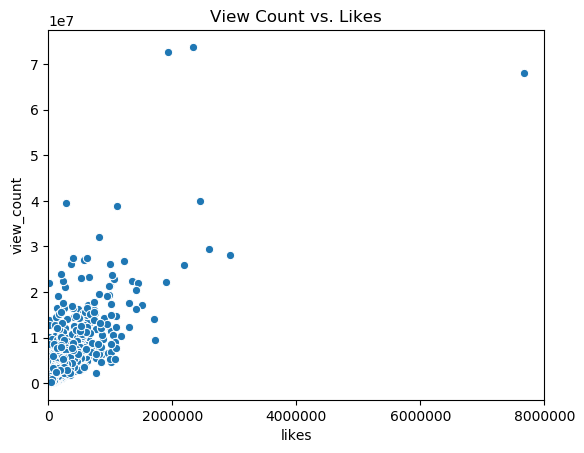

In [34]:
fig, ax = plt.subplots()

sns.scatterplot(data = us_gaming, x = "likes", y = "view_count", ax = ax)
plt.title("View Count vs. Likes")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

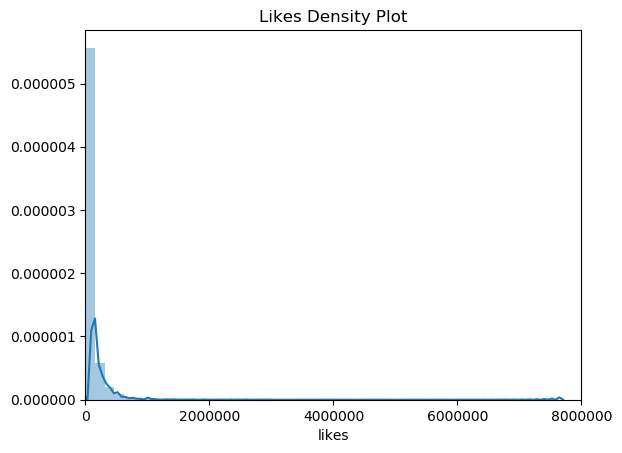

In [35]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

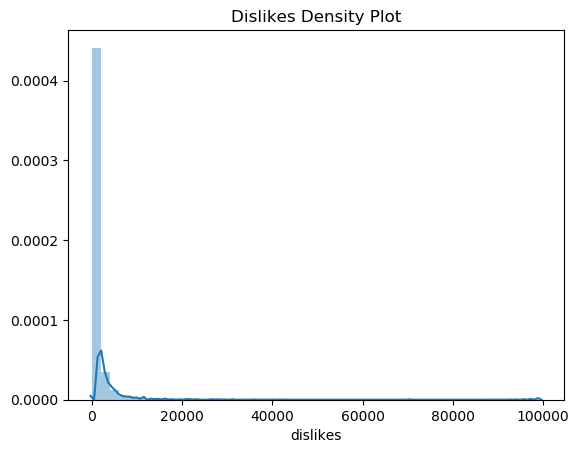

In [36]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

faze is a popular, legacy gaming brand at this point. Below the faze gaming organization 100t is charted as well, 100t is new gaming brand, although already find themselves very successful on YouTube. Looking at the comparison, faze, particularly prior to 2022, is the much stronger brand on YouTube, Perhaps when working out deals or collaborations with gaming brand with our creators, it would be more lucrative to attach our creators to faze's brand rather than 100t. 

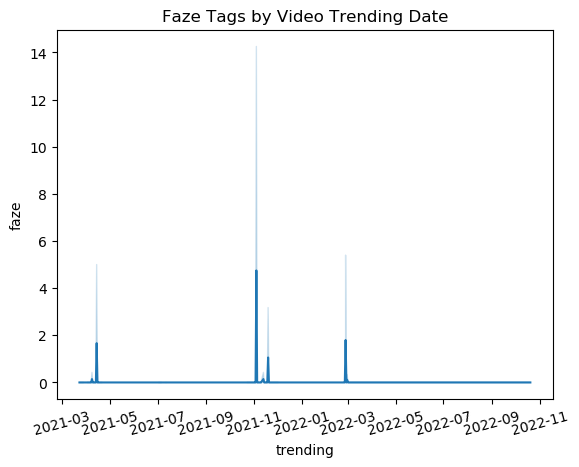

In [37]:
sns.lineplot(x = us_gaming["trending"], y = tag_df["faze"])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

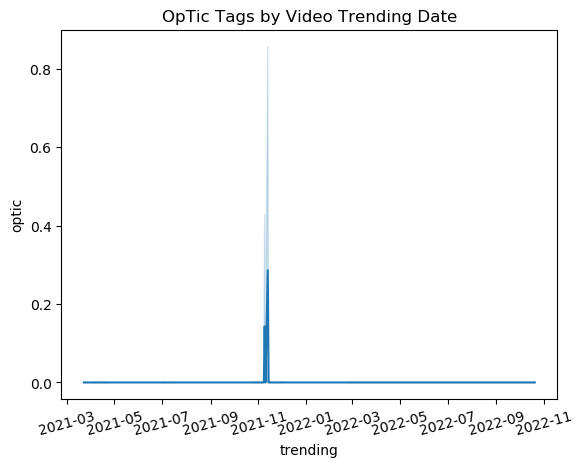

In [38]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['optic'])
plt.xticks(rotation = 15)
plt.title("OpTic Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title. 

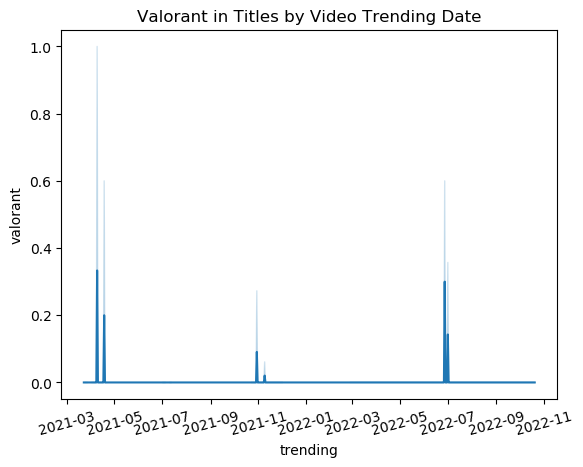

In [39]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

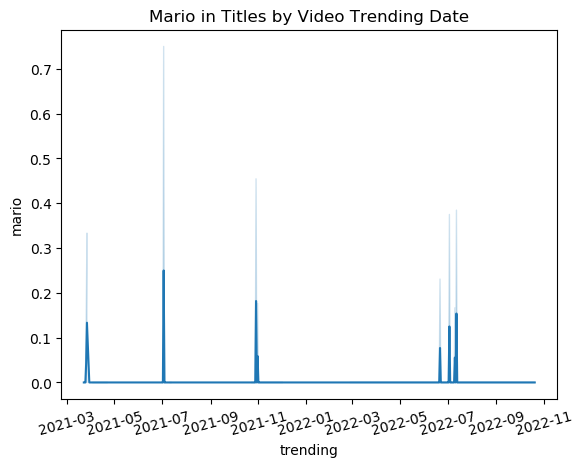

In [40]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()

### Feature Selection Final Decisions

Ultimately, as the goal of the project is to predict views, dislikes, likes, comment count, posting date, trending date, channelid, channel title, and thumbnail link cannot be used as predictors because we hope to predict the view count of the video before the video is posted. Perhaps in future projects an image recognition model can be used to predict views based upon thumbnail photos, but this project will be limited to text. Going forward, NLP techinques will be used to create a deep learning regression model from any combination of title, tags, and description in order to predict view count on videos as view count leads to greater growth for the creators. Particularly because, as the first scatterplot reveals above, high view count often lead to high likes which in turn leads to being boosted on the trending algorithm. The more eyes on the video, the more likely to trend. 

## Tokenization Transformations to Implement Deep Learning Modeling

Below is  a multi-step SKlearn processing container that will do the following:

1. Grab the gaming.csv from the s3 bucket where it was stored above. 

2. split the data using train/test/validation with 85/10/5 split

3. Commit the data to pre-processing transformations with distilBert and tensorflow. The data will be tokenized to extract ids and masks for title, tags, and description using distilbert. Then these ids and masks will be converted to tensorflow features and dataset in addition to view_count and video_id. This has been tracked using timestamps in the data column as well.

4. The newly transformed data is then stored in the output folder the output s3 bucket that is listed below.

In [41]:
# Timestamp the names of the different segments for tracking purposes over time.
timestamp = int(time.time())

# Creating the experiment for Youtube view count
experiment = Experiment.create(
    experiment_name="YouTube-View-Prediction-BERT-Experiment-{}".format(timestamp),
    description="YouTube View Prediction BERT Experiment",
    sagemaker_boto_client=sm,
)

# printing the experiment name
experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

Experiment name: YouTube-View-Prediction-BERT-Experiment-1680571855


In [42]:
# timestamp trial
timestamp = int(time.time())

# Creating trial using the experiment name and sagemaker
trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

# printing trial name
trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

Trial name: trial-1680571864


In [43]:
# store the trial name for later
%store trial_name

Stored 'trial_name' (str)


In [44]:
# setting the experiment configuration
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [45]:
# starting the feature store runtime within sagemaker
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [46]:
# timestamp prefix 
timestamp = int(time.time())

# setting the future store prefix for use in df-to-tokens-to-tensors.py file
feature_store_offline_prefix = "videos-feature-store-" + str(timestamp)

# print the full name of prefix
print(feature_store_offline_prefix)

videos-feature-store-1680571880


In [47]:
# create feature group name 
feature_group_name = "videos-feature-group-" + str(timestamp)

print(feature_group_name)

videos-feature-group-1680571880


In [48]:
# writing out our feature definitions to assign them to feature stores
# these definitions are for after the features have been transformed and prepped in addition to `date` that acts as the timestamp for the feature store
feature_definitions = [
    FeatureDefinition(feature_name="title_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="title_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="tags_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="tags_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="desc_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="desc_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="video_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="view_count", feature_type=FeatureTypeEnum.INTEGRAL),
]

In [49]:
# creating the feature group using the name and definition assigned above
feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=session)

print(feature_group)

FeatureGroup(name='videos-feature-group-1680571880', sagemaker_session=<sagemaker.session.Session object at 0x7fd0f3691ad0>, feature_definitions=[FeatureDefinition(feature_name='title_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='title_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='tags_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='tags_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='desc_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='desc_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='segment_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='video_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEn

In [50]:
# setting the instance type and established our train/test/validation splits
# max_seq_length may need to be adjusted
processing_instance_type = "ml.c5.xlarge"
processing_instance_count = 2
train_split_percentage = 0.85
validation_split_percentage = 0.05
test_split_percentage = 0.1
max_seq_length = 300

In [51]:
# creating the Sklearn processor to run the df-to-tokens-to-tensors.py file

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [52]:
# setting the processors inputs and outputs
processor.run(
    code="df-to-tokens-to-tensors.py",
    inputs=[
        ProcessingInput(
            input_name="gaming",
            source="s3://{}/youtubeStatistics/dfs/".format(bucket),
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", 
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation"
        ),
        ProcessingOutput(
            output_name="bert-test", 
            s3_upload_mode="EndOfJob", 
            source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--test-split-percentage",
        str(test_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2023-04-04-01-32-59-185


In [53]:
scikit_processing_job_name = processor.jobs[-1].describe()["ProcessingJobName"]
print(scikit_processing_job_name)

sagemaker-scikit-learn-2023-04-04-01-32-59-185


In [54]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name, sagemaker_session=session
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'gaming', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-692349450615/youtubeStatistics/dfs/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-04-01-32-59-185/input/code/df-to-tokens-to-tensors.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'bert-train', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-04-01-32-59-185/output/bert-train', 'LocalPath': '/opt/ml/processing/output/bert/train', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}, {'OutputName': 

In [55]:
# logs can be set to true to find errors when trouble shooting
running_processor.wait(logs=False)

..................................................................................................................................................................!

In [56]:
# obtain the location of the new s3 folders for the training/testing/validation data in order to implement modeling
processing_job_description = running_processor.describe()

output_config = processing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "bert-train":
        processed_train_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-validation":
        processed_validation_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-test":
        processed_test_uri = output["S3Output"]["S3Uri"]

print(processed_train_uri)
print(processed_validation_uri)
print(processed_test_uri)

s3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-04-01-32-59-185/output/bert-train
s3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-04-01-32-59-185/output/bert-validation
s3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-04-01-32-59-185/output/bert-test


This is the final transformation for the strings before modeling. The strings have been encoded/tokenized, placed into tensorflow tensors, made into a tensor dataset and ultimately transformed into a tensorflow dataset for modeling. The data has also been stored in the s3. 

## Model Creation/Training

Model creation and training will also be a script job that takes the tensors from the different folders within the s3 bucket to train and test the model within the script while revealing the results/progress here.

In [24]:
!aws s3 ls $processed_train_uri/

2023-04-02 22:21:25   15256479 part-algo-1-gaming.tfrecord
2023-04-02 22:21:25   15248241 part-algo-2-us_gaming.tfrecord


In [25]:
!aws s3 ls $processed_test_uri/

2023-04-02 22:21:26    1791302 part-algo-1-gaming.tfrecord
2023-04-02 22:21:26    1795366 part-algo-2-us_gaming.tfrecord


In [26]:
!aws s3 ls $processed_validation_uri/

2023-04-02 22:21:26     894130 part-algo-1-gaming.tfrecord
2023-04-02 22:21:26     898231 part-algo-2-us_gaming.tfrecord


In [145]:
input_train_data = TrainingInput(processed_train_uri+"/", distribution="ShardedByS3Key")
input_validation_data = TrainingInput(s3_data=processed_validation_uri+"/", distribution="ShardedByS3Key")
input_test_data = TrainingInput(s3_data=processed_test_uri+"/", distribution="ShardedByS3Key")

print(input_train_data)
print(input_validation_data.config)
print(input_test_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-02-22-07-16-846/output/bert-validation/', 'S3DataDistributionType': 'ShardedByS3Key'}}}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-02-22-07-16-846/output/bert-test/', 'S3DataDistributionType': 'ShardedByS3Key'}}}


In [135]:
epochs = 2
learning_rate = 0.001
epsilon = 0.000001
train_batch_size = 128
validation_batch_size = 128
test_batch_size = 128
train_steps_per_epoch = 10
validation_steps = 10
test_steps = 10
train_instance_count = 1
train_instance_type = "ml.p2.xlarge"
train_volume_size = 1024
use_xla = True
use_amp = True
freeze_bert_layer = False
enable_sagemaker_debugger = True
enable_checkpointing = False
enable_tensorboard = True
input_mode = "Pipe"
run_validation = True
run_test = True
run_sample_predictions = True

In [136]:
metrics_definitions = [
    {"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"},
    {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
    {"Name": "validation:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "validation:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
]

In [137]:
actions = rule_configs.ActionList()

rules = [ProfilerRule.sagemaker(rule_configs.ProfilerReport())]


hook_config = DebuggerHookConfig(
    hook_parameters={
        "save_interval": "10",  # number of steps
        "export_tensorboard": "true",
        "tensorboard_dir": "hook_tensorboard/",
    }
)

In [146]:
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10))

In [147]:
checkpoint_s3_prefix = "checkpoints/{}".format(str(uuid.uuid4()))
checkpoint_s3_uri = "s3://{}/{}/".format(bucket, checkpoint_s3_prefix)

print(checkpoint_s3_uri)

s3://sagemaker-us-east-1-492991381452/checkpoints/c359ccda-f845-400e-9a39-1af1ff6631d0/


In [151]:
estimator = TensorFlow(
    entry_point="model_construction.py",
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    checkpoint_base_path=checkpoint_s3_uri,
    py_version="py37",
    framework_version="2.3.1",
    hyperparameters={
        "epochs": epochs,
        "learning_rate": learning_rate,
        "epsilon": epsilon,
        "train_batch_size": train_batch_size,
        "validation_batch_size": validation_batch_size,
        "test_batch_size": test_batch_size,
        "train_steps_per_epoch": train_steps_per_epoch,
        "validation_steps": validation_steps,
        "test_steps": test_steps,
        "use_xla": use_xla,
        "use_amp": use_amp,
        "max_seq_length": max_seq_length,
        "freeze_bert_layer": freeze_bert_layer,
        "enable_sagemaker_debugger": enable_sagemaker_debugger,
        "enable_checkpointing": enable_checkpointing,
        "enable_tensorboard": enable_tensorboard,
        "run_validation": run_validation,
        "run_test": run_test,
        "run_sample_predictions": run_sample_predictions,
    },
    input_mode=input_mode,
    metric_definitions=metrics_definitions,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [152]:
experiment_config = {"ExperimentName": experiment_name, "TrialName": trial_name, "TrialComponentDisplayName": "train"}

In [155]:
estimator.fit(
    inputs={"train": input_train_data, "validation": input_validation_data, "test": input_test_data},
    experiment_config=experiment_config,
    wait=False,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-04-03-01-51-12-118


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p2.xlarge for training job usage' is 1 Instances, with current utilization of 1 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [156]:
training_job_name = estimator.latest_training_job.name
print("Training Job Name:  {}".format(training_job_name))

AttributeError: 'NoneType' object has no attribute 'name'

In [157]:
%%time

estimator.latest_training_job.wait(logs=True)

AttributeError: 'NoneType' object has no attribute 'wait'

In [ ]:
estimator.training_job_analytics.dataframe()